In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(123)  # for reproducibility

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [4]:
from sklearn.preprocessing import MinMaxScaler
input_scaler = MinMaxScaler(feature_range = (0.01, 0.99))
output_scaler = MinMaxScaler(feature_range = (0.01, 0.99))

In [59]:
from estimator_data import EstimatorData

ID_OFFSET = 10000;
FEATURES  = 5;
TIMESTEPS = 437; # least number of timesteps in any simulation as it must be uniform
#print(TIMESTEPS)
train_inputs_all_sims  = np.zeros((4,TIMESTEPS,(FEATURES+1)*3)); #one extra row for robot items
train_outputs_all_sims = np.zeros((4,TIMESTEPS,4))
z=0;

for n in range (4):
    data_in_string = "alphred_dataset" + str(n+2) +".txt";
    est = EstimatorData(data_in_string);
    z=0;
    feature_positions_list = est.feature_positions;

    covariance = np.array(est.Psb[0:2,0:2,:])
    covariance = np.swapaxes(covariance,0,2)
    covariance = np.reshape(covariance[0:TIMESTEPS], (TIMESTEPS,4))

    feature_ids_list = est.feature_ids;
    feature_ids = np.zeros(len(feature_ids_list));

    robot_position = est.Tsb;
    robot_position = np.swapaxes(robot_position,0,1)

    feature_positions = np.zeros((TIMESTEPS,FEATURES+1,3)); #one extra row for robot items

    for i in range (TIMESTEPS):
        feature_positions_temp = np.zeros((FEATURES,3));
        if feature_ids_list[i].size != 0:
            for j in range (len(feature_ids_list[i])):
                feat_id = (feature_ids_list[i][j]) - ID_OFFSET;
                if j < FEATURES:
                    feature_positions_temp[j] = np.array(feature_positions_list[i][j]);
        rob_pos = np.reshape(robot_position[i], (1,3))
        total_timestep_items = np.append(feature_positions_temp, rob_pos,axis=0);
        feature_positions[i] = total_timestep_items;
    #print(feature_positions.shape)
    train_inputs  = np.reshape(feature_positions,(TIMESTEPS,(FEATURES*3)+3));
    train_outputs = covariance;

    train_inputs  = input_scaler.fit_transform(train_inputs)
    
    
    train_inputs_all_sims[n]  = train_inputs;
    train_outputs_all_sims[n] = train_outputs;
train_outputs = output_scaler.fit_transform(train_outputs)

test_inputs  = train_inputs_all_sims[3]
test_outputs = train_outputs_all_sims[3]
train_inputs  = train_inputs_all_sims[0:3]
train_outputs = train_outputs_all_sims[0:3]
test_inputs  = np.expand_dims(test_inputs,axis=0)
test_outputs = np.expand_dims(test_outputs,axis=0)

print("Data Successfully Concatenated.")
#print(train_inputs.shape);
#print(train_outputs.shape);
#print(test_inputs.shape);
#print(test_outputs.shape);


Data Successfully Concatenated.


In [61]:
ACTIVATION_1 = 'relu';
EPOCHS = 100;

model = tf.keras.Sequential()
model.add(layers.SimpleRNN(256, input_shape=(None, (FEATURES*3)+3), activation=ACTIVATION_1, return_sequences=True))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation=ACTIVATION_1))
#model.add(layers.Reshape((100, 256)))
model.add(layers.SimpleRNN(128, input_shape=(None, None), activation=ACTIVATION_1, return_sequences=True))
#model.add(layers.Dropout(0.1))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(32, activation=ACTIVATION_1))
#model.add(layers.Reshape((100, 32)))
model.add(layers.SimpleRNN(32, activation=ACTIVATION_1, return_sequences=True))
model.add(layers.SimpleRNN(16, activation=ACTIVATION_1, return_sequences=True))
#model.add(layers.SimpleRNN(8, activation=ACTIVATION_1, return_sequences=True))
model.add(layers.SimpleRNN(4, activation=ACTIVATION_1, return_sequences=True))

#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
model.summary()
history = model.fit(train_inputs, train_outputs,validation_data=(test_inputs, test_outputs), batch_size=16, epochs=EPOCHS, verbose=2)
model.save('alphred_rnn_2.h5')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_55 (SimpleRNN)    (None, None, 256)         70400     
_________________________________________________________________
dense_22 (Dense)             (None, None, 256)         65792     
_________________________________________________________________
simple_rnn_56 (SimpleRNN)    (None, None, 128)         49280     
_________________________________________________________________
dense_23 (Dense)             (None, None, 32)          4128      
_________________________________________________________________
simple_rnn_57 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_58 (SimpleRNN)    (None, None, 16)          784       
_________________________________________________________________
simple_rnn_59 (SimpleRNN)    (None, None, 4)         

Epoch 72/100
3/3 - 1s - loss: 0.0070 - accuracy: 0.5988 - val_loss: 0.0069 - val_accuracy: 0.2426
Epoch 73/100
3/3 - 1s - loss: 0.0070 - accuracy: 0.5995 - val_loss: 0.0069 - val_accuracy: 0.2426
Epoch 74/100
3/3 - 1s - loss: 0.0070 - accuracy: 0.5995 - val_loss: 0.0069 - val_accuracy: 0.2426
Epoch 75/100
3/3 - 1s - loss: 0.0070 - accuracy: 0.6003 - val_loss: 0.0069 - val_accuracy: 0.2426
Epoch 76/100
3/3 - 1s - loss: 0.0070 - accuracy: 0.6003 - val_loss: 0.0069 - val_accuracy: 0.2426
Epoch 77/100
3/3 - 1s - loss: 0.0070 - accuracy: 0.6003 - val_loss: 0.0069 - val_accuracy: 0.2426
Epoch 78/100
3/3 - 1s - loss: 0.0070 - accuracy: 0.6003 - val_loss: 0.0069 - val_accuracy: 0.2426
Epoch 79/100
3/3 - 1s - loss: 0.0070 - accuracy: 0.6003 - val_loss: 0.0069 - val_accuracy: 0.2426
Epoch 80/100
3/3 - 1s - loss: 0.0070 - accuracy: 0.6003 - val_loss: 0.0069 - val_accuracy: 0.2426
Epoch 81/100
3/3 - 1s - loss: 0.0070 - accuracy: 0.6003 - val_loss: 0.0069 - val_accuracy: 0.2426
Epoch 82/100
3/3 - 1

In [63]:
# This is already calculated in the mpc code, I just needed an example data input.
current_state = 0;
future_states_desired = 10;
MPC_Generated_Measurements = train_inputs[0, current_state:current_state + future_states_desired,:]

####### THIS CODE IS USED TO MAKE PREDICTIONS #######
from keras.models import load_model
#model = load_model('mpc_rnn.h5')
RNN_input = MPC_Generated_Measurements[np.newaxis,:]
RNN_output = model.predict(RNN_input)[0]
covariance_predictions = output_scaler.inverse_transform(RNN_output)

###### Demonstrate Functionality ######
truth_output = train_outputs[0, current_state:current_state + future_states_desired,:]
truth_output = output_scaler.inverse_transform(truth_output)
#print(RNN_input[0])
#print(input_scaler.inverse_transform(RNN_input[0]))
#print(RNN_output)
print("Covariance Predictions:")
print(covariance_predictions)
print("Covariance Truths:")
print(truth_output)

Covariance Predictions:
[[-0.00973311 -0.00021811 -0.00021811 -0.00972904]
 [-0.00973311 -0.00021811 -0.00021811 -0.00972904]
 [-0.00973311 -0.00021811 -0.00021811 -0.00972904]
 [-0.00973311 -0.00021811 -0.00021811 -0.00972904]
 [-0.00973311 -0.00021811 -0.00021811 -0.00972904]
 [-0.00973311 -0.00021811 -0.00021811 -0.00972904]
 [-0.00973311 -0.00021811 -0.00021811 -0.00972904]
 [-0.00973311 -0.00021811 -0.00021811 -0.00972904]
 [-0.00973311 -0.00021811 -0.00021811 -0.00972904]
 [-0.00973311 -0.00021811 -0.00021811 -0.00972904]]
Covariance Truths:
[[-9.63564572e-03 -2.18114127e-04 -2.18114127e-04 -9.63157133e-03]
 [-9.63564572e-03 -2.18114127e-04 -2.18114127e-04 -9.63157133e-03]
 [ 9.23461454e-01 -2.18114127e-04 -2.18114127e-04  9.23461588e-01]
 [ 1.10639741e-01 -2.18107211e-04 -2.18107211e-04  1.10666336e-01]
 [-7.84467683e-03 -2.18108607e-04 -2.18108607e-04 -7.82484316e-03]
 [ 1.09419293e-01 -2.18108608e-04 -2.18108608e-04  1.09438629e-01]
 [-9.70823532e-03 -2.18108971e-04 -2.1810897

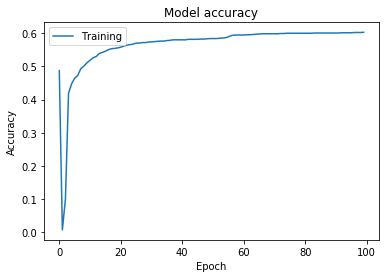

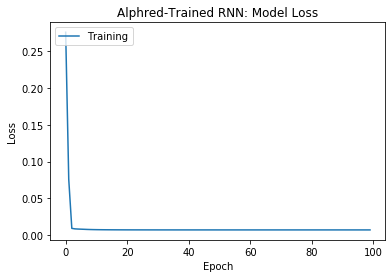

In [62]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Alphred-Trained RNN: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper left')
plt.show()